<a href="https://colab.research.google.com/github/victorhss21/Estudos_CD/blob/main/Algoritimos_de_Densidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Algoritimos de Densidade**

 Neste notebook, iremos tentar responder as seguintes perguntas:
>
> * **O que é?** (Motivação para criação & O que se propõe a resolver)
>
> * **Qual o seu funcionamento?** (Pressupostos & Lógica do algoritimo)
>
> * **Como utiliza-lo?** (Aplicação em python)
>
> * **Quais suas vantagens e limitações?** (Vantagen vs Limitações & Precauções)**
>
> * **Como valiar sua performance?** (Mensuração dos resultados)
>
> * **Quais as principais dicas prática que "mudam o jogo" em situações reais?** (Hacks & Dicas que mudam o jogo)

### **1. O que é? (Motivação e Proposta)**

**Motivação:**
Algoritmos de agrupamento tradicionais como o K-Means ou K-Medoids enfrentam dificuldades em algumas situações:
*   **Formato dos Clusters:** Eles tendem a assumir que os clusters têm formatos esféricos ou convexos e tamanhos similares. Falham em identificar clusters com formatos arbitrários (e.g., alongados, em "C", anéis).
*   **Necessidade de 'K':** Exigem que o número de clusters (K) seja pré-definido, o que nem sempre é conhecido a priori.
*   **Sensibilidade a Outliers:** Outliers (ruído) podem distorcer significativamente os centróides/medoids e, consequentemente, os limites dos clusters.

**Proposta do DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**
DBSCAN foi proposto em 1996 por Martin Ester, Hans-Peter Kriegel, Jörg Sander e Xiaowei Xu para superar essas limitações. Sua proposta central é:
*   **Agrupar por Densidade:** Definir clusters como áreas densas de pontos no espaço de features, separadas por áreas de baixa densidade.
*   **Identificar Formatos Arbitrários:** Por se basear em conectividade de densidade local, consegue encontrar clusters de qualquer formato.
*   **Detectar Ruído (Outliers):** Explicitamente identifica pontos que não pertencem a nenhum cluster denso, classificando-os como ruído.
*   **Não Exigir 'K' Predefinido:** O número de clusters emerge naturalmente da distribuição dos dados e dos parâmetros do algoritmo, não sendo um input direto.

Em essência, DBSCAN busca responder: "Quais pontos estão densamente conectados entre si?".

### **2. Qual o seu funcionamento? (Pressupostos e Lógica)**

**Pressupostos:**
*   **Clusters são regiões de alta densidade separadas por regiões de baixa densidade.**
*   A densidade local ao redor de um ponto pode ser medida contando quantos outros pontos estão dentro de uma determinada vizinhança.

**Lógica do Algoritmo (Conceitos Chave):**

1.  **`eps` (epsilon - ε):** É um parâmetro de **distância**. Define o **raio da vizinhança ao redor de um ponto**. Qualquer outro ponto dentro dessa distância é considerado um "vizinho". A escolha de `eps` é crucial e **depende da escala dos dados** (daí a **importância da padronização**).
2.  **`min_samples` (MinPts):** É um parâmetro de **contagem**. Define o número mínimo de pontos (incluindo o próprio ponto) que devem existir dentro da vizinhança `eps` para que um ponto seja considerado um "ponto central" (core point).
3.  **Ponto Central (Core Point):** Um ponto é um *core point* se sua vizinhança de raio `eps` contém pelo menos `min_samples` pontos (incluindo ele mesmo). Estes são os pontos que estão no "interior" de um cluster denso.
4.  **Ponto de Fronteira (Border Point):** Um ponto é um *border point* se ele *não* é um *core point* (tem menos de `min_samples` vizinhos em `eps`), mas é vizinho de *pelo menos um* *core point*. Eles ficam nas bordas dos clusters.
5.  **Ponto de Ruído (Noise Point / Outlier):** Um ponto que não é nem *core point* nem *border point*. Ele não está em uma região densa e nem na fronteira de uma. DBSCAN explicitamente os identifica (geralmente com o label -1).

**Conectividade por Densidade:**

*   **Diretamente Alcançável por Densidade (Directly Density-Reachable):** Um ponto `p` é diretamente alcançável por densidade a partir de um ponto `q` se `p` está dentro da vizinhança `eps` de `q`, e `q` é um *core point*. (A relação não é simétrica se `p` for um *border point*).
*   **Alcançável por Densidade (Density-Reachable):** Um ponto `p` é alcançável por densidade a partir de um ponto `q` se existe uma cadeia de pontos `p1, p2, ..., pn` onde `p1 = q` e `pn = p`, tal que cada `pi+1` é *diretamente alcançável por densidade* a partir de `pi`. (Essencialmente, você pode "pular" de core point em core point até chegar perto de `p`).
*   **Conectado por Densidade (Density-Connected):** Dois pontos `p` e `q` são conectados por densidade se existe um ponto `o` (necessariamente um *core point*) tal que tanto `p` quanto `q` são *alcançáveis por densidade* a partir de `o`. Esta relação *é* simétrica e define os clusters.

**Algoritmo Passo-a-Passo:**

1.  **Inicialização:** Todos os pontos começam como "não visitados".
2.  **Iteração:** Para cada ponto `P` não visitado:

  a. Marcar `P` como "visitado".

  b. Encontrar todos os vizinhos de `P` dentro do raio `eps`.

  c. **Verificar se é Core Point:** Se o número de vizinhos for menor que `min_samples`, marcar `P` temporariamente como Ruído (pode mudar depois se for vizinho de um core point). Continuar para o próximo ponto não visitado.

  d. **Expandir Cluster:** Se o número de vizinhos for maior ou igual a `min_samples`, `P` é um *core point*. Criar um novo cluster e adicionar `P` a ele.

      i. Adicionar todos os vizinhos de `P` a uma fila (ou conjunto) de processamento `Q`.
      
      ii. **Processar a Fila:** Enquanto `Q` não estiver vazia:

      - Pegar um ponto `P'` de `Q`.
      - Se `P'` era Ruído, mudar seu status para *border point* e adicioná-lo ao cluster atual.
      - Se `P'` já foi visitado (e não era Ruído), continuar (já faz parte deste ou de outro cluster).
      - Marcar `P'` como "visitado".
      - Adicionar `P'` ao cluster atual.
      - Encontrar os vizinhos de `P'` dentro de `eps`.
      - **Expandir Mais:** Se `P'` também for um *core point* (tiver >= `min_samples` vizinhos), adicionar todos os seus vizinhos *não visitados* ou que eram *Ruído* à fila `Q`.
      
3.  **Fim:** Quando todos os pontos foram visitados, o processo termina. Os pontos marcados como Ruído são os outliers. Os clusters formados contêm os *core points* e *border points* conectados por densidade.

### 3. Como utilizá-lo? (Aplicação em Python)

Bibliotecas importadas com sucesso.

Conjunto de dados 'winequality-white.csv' carregado.
Shape inicial: (4898, 12)

Features selecionadas para clusterização: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Shape dos dados de features: (4898, 11)

Nenhum dado ausente encontrado.

Dados padronizados com StandardScaler.
Shape dos dados escalados: (4898, 11)

Dimensões (D) = 11. Sugestão heurística para min_samples = 2 * D = 22
Valores de min_samples a serem explorados: [22, 27, 32]

Calculando distâncias para o 21-ésimo vizinho mais próximo para estimar eps...


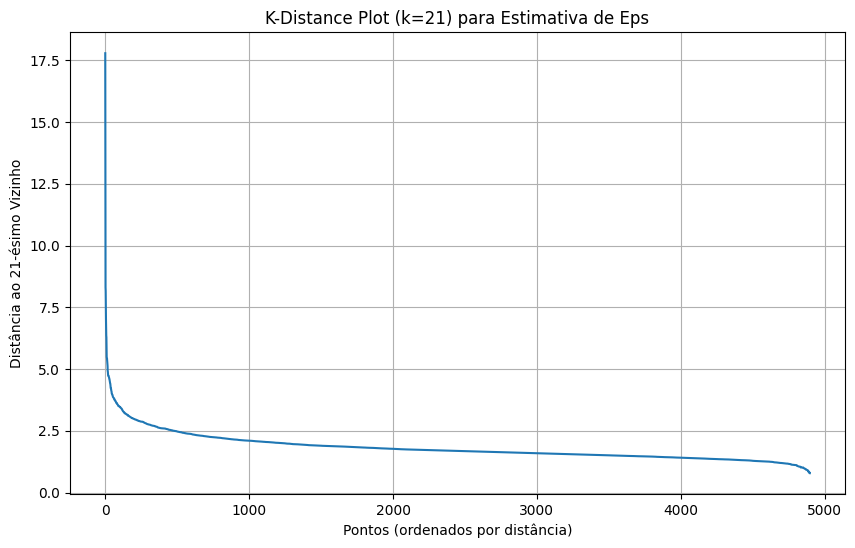


Valor de 'eps' estimado visualmente do gráfico: 2.8
Valores de 'eps' a serem explorados: ['2.50', '2.80', '3.10']

Iniciando análise exploratória com métricas para diferentes parâmetros...
  Testando: eps=2.50, min_samples=22 -> Clusters=2, Ruído=133 (2.7%)
    Métricas (sem ruído): Silhueta=0.3494, Davies-Bouldin=0.8740, Calinski-Harabasz=65.5
  Testando: eps=2.50, min_samples=27 -> Clusters=1, Ruído=187 (3.8%)
    Não calculando métricas (Número de clusters=1)
  Testando: eps=2.50, min_samples=32 -> Clusters=1, Ruído=204 (4.2%)
    Não calculando métricas (Número de clusters=1)
  Testando: eps=2.80, min_samples=22 -> Clusters=1, Ruído=86 (1.8%)
    Não calculando métricas (Número de clusters=1)
  Testando: eps=2.80, min_samples=27 -> Clusters=1, Ruído=90 (1.8%)
    Não calculando métricas (Número de clusters=1)
  Testando: eps=2.80, min_samples=32 -> Clusters=1, Ruído=121 (2.5%)
    Não calculando métricas (Número de clusters=1)
  Testando: eps=3.10, min_samples=22 -> Clusters=1, Ru

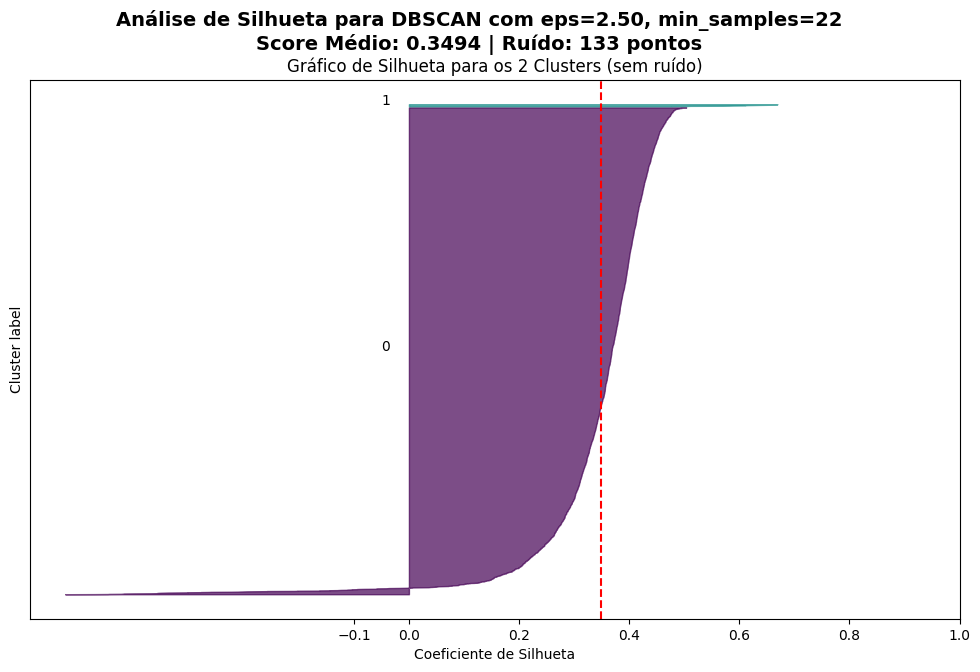


--- Perfis Médios dos Clusters (Coordenadas Paralelas - Plotly GO - Dados Originais) ---

Perfis médios dos clusters (escala original) - PARA PLOT:
         fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster                                                                 
0             6.845162          0.273949     0.329661        6.374568   
1             6.685714          0.278333     0.608095        1.209524   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
cluster                                                                   
0         0.044175            35.109718            137.734612  0.993990   
1         0.146571            44.714286            131.809524  0.993259   

               pH  sulphates    alcohol  
cluster                                  
0        3.189254   0.488409  10.521581  
1        3.084286   0.430476   9.257143  



--- Perfis dos Clusters (Radar Plots em Grade - Usando Médias Escaladas) ---

Gerando Radar Plots (Clusters: 2) em grade - usando PERFIS MÉDIOS ESCALADOS...


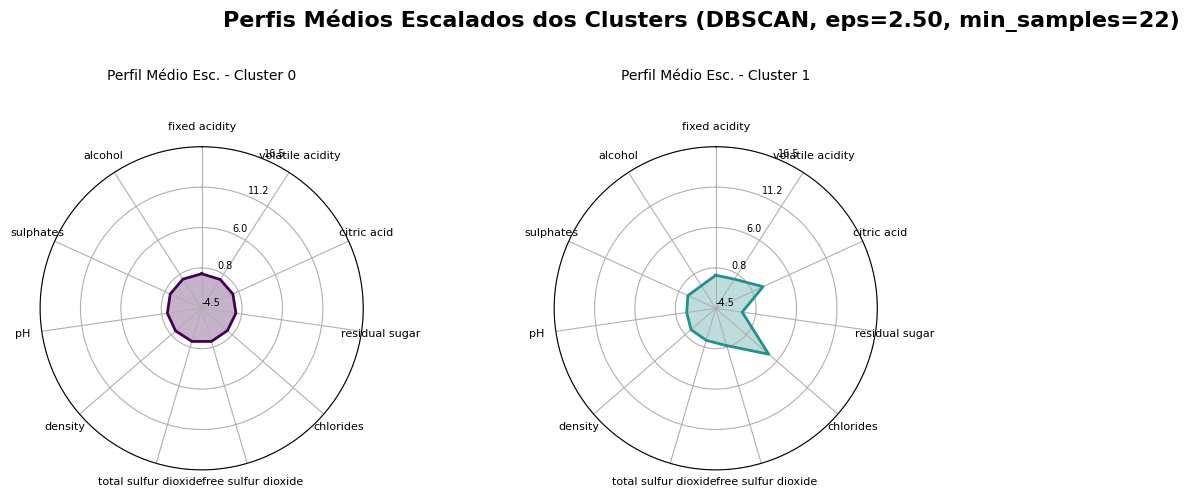


--- Análise DBSCAN Concluída ---
Utilizado DBSCAN com eps=2.50 e min_samples=22.
Encontrados 2 clusters e 133 pontos de ruído.
Analise os perfis dos clusters (Coordenadas Paralelas e Radar Plots) para interpretação.


In [2]:
# --- 1. Importando bibliotecas ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors # Para ajudar a escolher Eps
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples # Para plot de silhueta por amostra
from sklearn.impute import SimpleImputer
import math
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("Bibliotecas importadas com sucesso.")

# --- 2. Carregando conjunto de dados ---
try:
    df = pd.read_csv('winequality-white.csv', sep=',')
    print("\nConjunto de dados 'winequality-white.csv' carregado.")
    print(f"Shape inicial: {df.shape}")
except FileNotFoundError:
    print("\nErro: Arquivo 'winequality-white.csv' não encontrado.")
    exit()

# Guardar dados originais para referência posterior
df_original = df.copy()

# --- 3. Pré-processamento dos dados ---
features = df.columns.drop('quality')
X_original = df[features].copy() # Guardar features originais
print(f"\nFeatures selecionadas para clusterização: {list(features)}")
print(f"Shape dos dados de features: {X_original.shape}")

# Tratamento de NaNs (Embora neste dataset não haja, é uma boa prática)
if X_original.isnull().sum().sum() > 0:
    print(f"\nTratando {X_original.isnull().sum().sum()} dados ausentes...")
    imputer = SimpleImputer(strategy='median')
    # Aplicar imputer e manter como DataFrame pandas
    X_imputed = pd.DataFrame(imputer.fit_transform(X_original), columns=features, index=X_original.index)
    print("Dados ausentes tratados com a mediana.")
else:
    print("\nNenhum dado ausente encontrado.")
    X_imputed = X_original

# Padronização (CRUCIAL para DBSCAN, pois 'eps' é uma distância)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
print("\nDados padronizados com StandardScaler.")
print(f"Shape dos dados escalados: {X_scaled.shape}")

# --- 4. Análise para Especificar Parâmetros (eps e min_samples) ---

# 4.1 Escolhendo min_samples
# Heurística comum: min_samples >= D + 1, onde D é o número de dimensões.
# Outra heurística comum: min_samples = 2 * D
# Vamos usar a segunda heurística como ponto de partida.
D = X_scaled.shape[1]
min_samples_heuristic = 2 * D
print(f"\nDimensões (D) = {D}. Sugestão heurística para min_samples = 2 * D = {min_samples_heuristic}")
# Vamos explorar valores próximos a esta heurística, por exemplo:
min_samples_options = [min_samples_heuristic, min_samples_heuristic + 5, min_samples_heuristic + 10]
print(f"Valores de min_samples a serem explorados: {min_samples_options}")

# 4.2 Escolhendo eps usando o método do K-distance Plot (Gráfico de Distância ao k-ésimo Vizinho)
# Calculamos a distância de cada ponto ao seu k-ésimo vizinho mais próximo, onde k = min_samples - 1.
# Plotamos essas distâncias ordenadas e procuramos um "cotovelo" (elbow) na curva.
# O valor de 'eps' no cotovelo é um bom candidato.

k_neighbor = min_samples_heuristic - 1 # k para NearestNeighbors é min_samples - 1
print(f"\nCalculando distâncias para o {k_neighbor}-ésimo vizinho mais próximo para estimar eps...")
nn = NearestNeighbors(n_neighbors=k_neighbor + 1) # +1 porque inclui o próprio ponto
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

# Pegar a distância ao k-ésimo vizinho (a última coluna, pois estão ordenadas)
k_distances = distances[:, k_neighbor]
k_distances_sorted = np.sort(k_distances)[::-1] # Ordenar decrescente para plot mais claro do cotovelo

plt.figure(figsize=(10, 6))
plt.plot(k_distances_sorted)
plt.title(f'K-Distance Plot (k={k_neighbor}) para Estimativa de Eps')
plt.xlabel('Pontos (ordenados por distância)')
plt.ylabel(f'Distância ao {k_neighbor}-ésimo Vizinho')
plt.grid(True)
plt.show()

# !!! IMPORTANTE: Analise o gráfico acima para encontrar o "cotovelo" !!!
# O valor de 'eps' no eixo Y onde a curva começa a subir mais abruptamente é um bom candidato.
# Exemplo: Se o cotovelo parecer estar em torno de Y=2.5, use esse valor ou valores próximos.
# Ajuste o valor abaixo baseado na sua análise visual do gráfico:
estimated_eps_from_plot = 2.8 # <--- VALOR A SER AJUSTADO PELO USUÁRIO APÓS VER O GRÁFICO
print(f"\nValor de 'eps' estimado visualmente do gráfico: {estimated_eps_from_plot}")
# Vamos explorar valores de eps próximos a este.
eps_options = [estimated_eps_from_plot - 0.3, estimated_eps_from_plot, estimated_eps_from_plot + 0.3]
eps_options = [e for e in eps_options if e > 0] # Garantir que eps seja positivo
print(f"Valores de 'eps' a serem explorados: {[f'{e:.2f}' for e in eps_options]}")


# 4.3 Avaliação Exploratória com Métricas de Clusterização
# Vamos testar combinações de eps e min_samples e avaliar com métricas.
# CUIDADO: Essas métricas foram desenhadas para algoritmos baseados em partições (como K-Means).
# Sua interpretação com DBSCAN (que tem ruído e formas arbitrárias) requer cautela.
# Elas podem ajudar a comparar *relativamente* diferentes parametrizações de DBSCAN.

print("\nIniciando análise exploratória com métricas para diferentes parâmetros...")
results = []

for eps in eps_options:
    for min_samples in min_samples_options:
        dbscan_temp = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
        labels_temp = dbscan_temp.fit_predict(X_scaled)

        # Identificar clusters e ruído
        unique_labels = set(labels_temp)
        n_clusters_ = len(unique_labels) - (1 if -1 in unique_labels else 0)
        n_noise_ = list(labels_temp).count(-1)

        print(f"  Testando: eps={eps:.2f}, min_samples={min_samples} -> Clusters={n_clusters_}, Ruído={n_noise_} ({n_noise_/len(labels_temp)*100:.1f}%)")

        # Calcular métricas APENAS se houver mais de 1 cluster (excluindo ruído)
        # E se houver pontos não-ruído
        if n_clusters_ > 1 and n_clusters_ < len(X_scaled): # Evitar caso trivial de 1 cluster ou todos ruído
            # Filtrar ruído para calcular métricas
            X_filtered = X_scaled[labels_temp != -1]
            labels_filtered = labels_temp[labels_temp != -1]

            if len(labels_filtered) > 0 and len(set(labels_filtered)) > 1: # Checagem dupla
                try:
                    silhouette_avg = silhouette_score(X_filtered, labels_filtered)
                except ValueError:
                     silhouette_avg = -1 # Não calculável
                try:
                    davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered)
                except ValueError:
                    davies_bouldin = -1
                try:
                    calinski_harabasz = calinski_harabasz_score(X_filtered, labels_filtered)
                except ValueError:
                    calinski_harabasz = -1

                print(f"    Métricas (sem ruído): Silhueta={silhouette_avg:.4f}, Davies-Bouldin={davies_bouldin:.4f}, Calinski-Harabasz={calinski_harabasz:.1f}")
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters_,
                    'n_noise': n_noise_,
                    'silhouette': silhouette_avg,
                    'davies_bouldin': davies_bouldin,
                    'calinski_harabasz': calinski_harabasz
                })
            else:
                 print("    Não foi possível calcular métricas (poucos clusters/pontos após filtrar ruído).")

        else:
            print(f"    Não calculando métricas (Número de clusters={n_clusters_})")


# Analisar resultados - O "melhor" é subjetivo com DBSCAN.
# - Silhueta mais alta é geralmente melhor (clusters densos e bem separados).
# - Davies-Bouldin mais baixo é melhor (clusters compactos e bem separados).
# - Calinski-Harabasz mais alto é melhor (maior razão entre variância inter-cluster e intra-cluster).
# CONSIDERE TAMBÉM:
# - Número de clusters gerados: Faz sentido para o problema?
# - Percentual de ruído: Um percentual muito alto pode indicar `eps` muito pequeno ou `min_samples` muito grande. Muito baixo pode indicar o contrário.

print("\n--- Resumo da Análise Exploratória ---")
results_df = pd.DataFrame(results)
print(results_df)

# Escolha dos parâmetros FINAIS - Pode ser baseado nas métricas, no K-distance plot, ou conhecimento do domínio.
# Exemplo: Escolher baseado em uma combinação (e.g., boa silhueta, DB baixo, número razoável de clusters/ruído)
# Aqui, vamos usar os valores iniciais estimados, mas você deve ajustar baseado nos resultados!
final_eps = estimated_eps_from_plot # Use o valor do K-distance plot ou da tabela acima
final_min_samples = min_samples_heuristic # Use o valor heurístico ou da tabela acima

# Se a tabela de resultados for vazia ou os resultados forem ruins, ajuste os ranges de eps/min_samples e rode de novo.
if results_df.empty:
    print("\nAVISO: Nenhuma combinação de parâmetros gerou clusters válidos para cálculo de métricas.")
    print(f"Usando valores iniciais: eps={final_eps:.2f}, min_samples={final_min_samples}. Pode ser necessário ajustar!")
else:
    # Exemplo de como escolher baseado em métricas (pode precisar de lógica mais sofisticada)
    # Ordenar por Silhueta (desc), depois DB (asc), depois CH (desc)
    results_df_sorted = results_df.sort_values(by=['silhouette', 'davies_bouldin', 'calinski_harabasz'], ascending=[False, True, False])
    print("\nMelhores combinações encontradas (ordenadas por Silhueta desc, DB asc, CH desc):")
    print(results_df_sorted.head())
    # Pegar a melhor combinação encontrada
    best_params = results_df_sorted.iloc[0]
    final_eps = best_params['eps']
    final_min_samples = int(best_params['min_samples']) # Garantir que é int
    print(f"\n--> Escolhendo parâmetros finais baseados na melhor métrica combinada: eps={final_eps:.2f}, min_samples={final_min_samples}")


# --- 5. Criação dos clusters FINAIS com DBSCAN ---
print(f"\nCriando clusters finais com DBSCAN (eps={final_eps:.2f}, min_samples={final_min_samples})...")
dbscan = DBSCAN(eps=final_eps, min_samples=final_min_samples, metric='euclidean', n_jobs=-1)
labels = dbscan.fit_predict(X_scaled)

# Adicionar labels ao DataFrame ORIGINAL para análise
df['cluster'] = labels
n_clusters_final = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_final = list(labels).count(-1)

print(f"\nNúmero de clusters encontrados: {n_clusters_final}")
print(f"Número de pontos de ruído (-1): {n_noise_final} ({n_noise_final/len(labels)*100:.1f}%)")
print(f"\nDistribuição dos vinhos por cluster (incluindo ruído -1):\n{df['cluster'].value_counts().sort_index()}")


# --- 6. Validação dos resultados ---

# 6.1 Validação da Qualidade do Agrupamento (Métricas Globais)
print("\n--- Validação Final (Métricas Globais - calculadas sem ruído) ---")
if n_clusters_final > 1 and n_clusters_final < len(X_scaled) and len(labels[labels != -1]) > 0:
    X_final_filtered = X_scaled[labels != -1]
    labels_final_filtered = labels[labels != -1]
    if len(set(labels_final_filtered)) > 1: # Checagem final
        final_sil_score = silhouette_score(X_final_filtered, labels_final_filtered)
        final_db_score = davies_bouldin_score(X_final_filtered, labels_final_filtered)
        final_ch_score = calinski_harabasz_score(X_final_filtered, labels_final_filtered)
        print(f"Score Médio de Silhueta (sem ruído): {final_sil_score:.4f}")
        print(f"Davies-Bouldin Index (sem ruído): {final_db_score:.4f}")
        print(f"Calinski-Harabasz Index (sem ruído): {final_ch_score:.1f}")
    else:
        print("Não foi possível calcular métricas finais (clusters insuficientes após remover ruído).")
else:
    print("Não foi possível calcular métricas finais (Número de clusters ou pontos insuficientes).")


# 6.2 Validação da Qualidade (Silhouette Plot por Amostra)
# Mostra quão bem cada ponto se encaixa em seu cluster comparado a outros clusters.
if n_clusters_final > 1 and n_clusters_final < len(X_scaled) and len(labels[labels != -1]) > 0:
    print("\nGerando gráfico de Silhueta por amostra...")
    X_final_filtered = X_scaled[labels != -1]
    labels_final_filtered = labels[labels != -1]
    if len(set(labels_final_filtered)) > 1:
        sample_silhouette_values = silhouette_samples(X_final_filtered, labels_final_filtered)

        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(12, 7)

        y_lower = 10
        for i in range(n_clusters_final):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[labels_final_filtered == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.viridis(float(i) / n_clusters_final) # Usar um colormap consistente
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title(f"Gráfico de Silhueta para os {n_clusters_final} Clusters (sem ruído)")
        ax1.set_xlabel("Coeficiente de Silhueta")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        silhouette_avg_final = silhouette_score(X_final_filtered, labels_final_filtered) # Recalcular para ter certeza
        ax1.axvline(x=silhouette_avg_final, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.suptitle((f'Análise de Silhueta para DBSCAN com eps={final_eps:.2f}, min_samples={final_min_samples}\n'
                      f'Score Médio: {silhouette_avg_final:.4f} | Ruído: {n_noise_final} pontos'),
                     fontsize=14, fontweight='bold')
        plt.show()
    else:
         print("Gráfico de Silhueta não gerado (clusters insuficientes após remover ruído).")
else:
     print("Gráfico de Silhueta não gerado (Número de clusters ou pontos insuficientes).")


# 6.3 Validação da Coerência (Perfis dos Clusters - Coordenadas Paralelas)
# Usar dados ORIGINAIS para interpretabilidade, calculando a MÉDIA por cluster (excluindo ruído)
print("\n--- Perfis Médios dos Clusters (Coordenadas Paralelas - Plotly GO - Dados Originais) ---")

# Calcular a média das features originais para cada cluster (excluindo ruído -1)
df_clusters_only = df[df['cluster'] != -1].copy()

if not df_clusters_only.empty and n_clusters_final > 0:
    cluster_profiles_original_mean = df_clusters_only.groupby('cluster')[features].mean()
    print("\nPerfis médios dos clusters (escala original) - PARA PLOT:")
    print(cluster_profiles_original_mean)

    # Preparar DataFrame para o plot de médias
    cluster_profiles_plot_df_go = cluster_profiles_original_mean.reset_index()

    # Construção com plotly.graph_objects para as MÉDIAS
    dimensions_mean = []
    for col in features:
        dimensions_mean.append(dict(
            range = [df_original[col].min(), df_original[col].max()], # Escala baseada nos dados originais totais
            label = col.replace('_', ' ').title(),
            values = cluster_profiles_plot_df_go[col] # Valores médios por cluster
        ))

    parcoords_trace_mean = go.Parcoords(
        line = dict(
            color = cluster_profiles_plot_df_go['cluster'], # ID numérico do cluster
            colorscale = px.colors.qualitative.Plotly, # Usar escala de cor categórica
            showscale = False
            ),
        dimensions = dimensions_mean,
        labelangle = -25 # Inclinar labels dos eixos
    )

    fig_parcoords_mean = go.Figure(data=[parcoords_trace_mean])
    fig_parcoords_mean.update_layout(
        title=f'Coordenadas Paralelas dos Perfis MÉDIOS dos Clusters (DBSCAN, eps={final_eps:.2f}, min_samples={final_min_samples}) - Dados Originais'
    )
    fig_parcoords_mean.show()
else:
    print("Não foi possível gerar o gráfico de coordenadas paralelas (nenhum cluster ou apenas ruído encontrado).")


# 6.4 Validação da Coerência (Perfis dos Clusters - Radar Plots em Grade)
# Usar as MÉDIAS dos dados ESCALADOS por cluster (excluindo ruído) para visualização consistente
print("\n--- Perfis dos Clusters (Radar Plots em Grade - Usando Médias Escaladas) ---")

# Calcular médias escaladas para plotagem de radar (excluindo ruído -1)
df_scaled_with_labels = pd.DataFrame(X_scaled, columns=features)
df_scaled_with_labels['cluster'] = labels
df_scaled_clusters_only = df_scaled_with_labels[df_scaled_with_labels['cluster'] != -1].copy()

if not df_scaled_clusters_only.empty and n_clusters_final > 0:
    cluster_profiles_scaled_mean = df_scaled_clusters_only.groupby('cluster')[features].mean()

    # --- Configuração da Grade de Plots de Radar ---
    n_cols_radar = 3
    # Garantir que n_rows_radar seja pelo menos 1
    n_rows_radar = math.ceil(n_clusters_final / n_cols_radar) if n_clusters_final > 0 else 0

    if n_rows_radar > 0: # Só plota se houver clusters
        fig_radar, axes_radar = plt.subplots(n_rows_radar, n_cols_radar,
                                             figsize=(n_cols_radar * 5, n_rows_radar * 5), # Ajustar tamanho
                                             subplot_kw=dict(polar=True))
        # Ajuste para caso de uma única linha/coluna ou único plot
        if n_clusters_final == 1:
             axes_radar = np.array([[axes_radar]]) # Forçar a ser 2D arraylike
        elif n_rows_radar == 1 or n_cols_radar == 1:
            axes_radar = axes_radar.reshape(n_rows_radar, n_cols_radar) # Forçar a ser 2D arraylike

        axes_radar = axes_radar.flatten() # Achatamento para fácil iteração

        categories = list(features)
        n_cat = len(categories)
        angles = [n / float(n_cat) * 2 * np.pi for n in range(n_cat)]
        angles += angles[:1]

        # Usar limites dos dados escalados para os eixos do radar
        min_val_global = np.floor(X_scaled.min()) - 0.5
        max_val_global = np.ceil(X_scaled.max()) + 0.5
        y_ticks = np.linspace(min_val_global, max_val_global, 5)
        y_tick_labels = [f"{val:.1f}" for val in y_ticks]

        print(f"\nGerando Radar Plots (Clusters: {n_clusters_final}) em grade - usando PERFIS MÉDIOS ESCALADOS...")
        # Iterar sobre os clusters REAIS encontrados (índices do groupby)
        cluster_ids = sorted(cluster_profiles_scaled_mean.index)

        for i, cluster_id in enumerate(cluster_ids):
            ax = axes_radar[i]
            # Usar o perfil MÉDIO escalado do cluster atual
            cluster_data_scaled_mean = cluster_profiles_scaled_mean.loc[cluster_id]
            values = cluster_data_scaled_mean.values.flatten().tolist()
            values += values[:1] # Fechar o radar

            color = plt.cm.viridis(float(i) / n_clusters_final) # Cor consistente

            ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster_id} (Média)", color=color)
            ax.fill(angles, values, alpha=0.3, color=color)
            ax.set_theta_offset(np.pi / 2)
            ax.set_theta_direction(-1)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(categories, size=8) # Tamanho da fonte menor
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_tick_labels, size=7) # Tamanho da fonte menor
            ax.set_ylim(min_val_global, max_val_global)
            ax.set_title(f"Perfil Médio Esc. - Cluster {cluster_id}", size=10, y=1.18) # Ajustar título

        # Ocultar eixos extras
        for i in range(n_clusters_final, len(axes_radar)):
            if i < len(axes_radar):
                axes_radar[i].set_visible(False)

        fig_radar.suptitle(f"Perfis Médios Escalados dos Clusters (DBSCAN, eps={final_eps:.2f}, min_samples={final_min_samples})", fontsize=16, fontweight='bold')
        fig_radar.tight_layout(rect=[0, 0.03, 1, 0.93]) # Ajustar layout
        plt.show()
    else:
        print("Não foi possível gerar os gráficos de radar (nenhum cluster encontrado).")

else:
    print("Não foi possível gerar os gráficos de radar (nenhum cluster ou apenas ruído encontrado).")


print("\n--- Análise DBSCAN Concluída ---")
print(f"Utilizado DBSCAN com eps={final_eps:.2f} e min_samples={final_min_samples}.")
print(f"Encontrados {n_clusters_final} clusters e {n_noise_final} pontos de ruído.")
print("Analise os perfis dos clusters (Coordenadas Paralelas e Radar Plots) para interpretação.")

### **4. Quais suas vantagens e limitações?**

**Vantagens:**

1.  **Não Requer 'K':** O número de clusters é determinado pelo algoritmo com base na densidade e conectividade, eliminando a necessidade de adivinhar 'K'.
2.  **Identifica Formatos Arbitrários:** Excelente para encontrar clusters não esféricos ou complexos que outros algoritmos falham em detectar.
3.  **Detecção Robusta de Ruído:** Identifica e isola explicitamente outliers (pontos de ruído), tornando o agrupamento dos clusters principais mais robusto.
4.  **Apenas Dois Parâmetros:** Requer apenas `eps` e `min_samples`, que têm um significado físico mais intuitivo (distância e densidade mínima) comparado ao 'K' do K-Means.
5.  **Determinístico (para pontos core/ruído):** Para uma dada parametrização, os pontos core e ruído serão sempre os mesmos. A atribuição de *border points* pode variar ligeiramente dependendo da ordem de processamento se ele for alcançável por mais de um cluster, mas na prática isso raramente é um problema significativo com boas implementações.

**Limitações e Precauções:**

1.  **Sensibilidade aos Parâmetros:** O resultado é bastante sensível à escolha de `eps` e `min_samples`. Pequenas variações podem levar a resultados drasticamente diferentes. Achar os valores ótimos pode ser desafiador (requer métodos como K-distance plot, tentativa e erro, ou conhecimento do domínio).
2.  **Dificuldade com Densidades Variáveis:** DBSCAN assume uma densidade mínima (definida por `eps` e `min_samples`) para formar um cluster. Ele tem dificuldade em encontrar clusters significativos que possuam densidades muito diferentes entre si. Clusters menos densos podem ser fundidos ou marcados como ruído. (Variantes como OPTICS ou HDBSCAN tentam resolver isso).
3.  **Mal Desempenho em Alta Dimensionalidade (Curse of Dimensionality):** Em espaços com muitas dimensões, o conceito de "vizinhança" (`eps`) perde significado, pois os pontos tendem a ficar esparsos e as distâncias entre eles se tornam menos discriminativas (a maioria dos pontos fica quase à mesma distância). A padronização é essencial, mas pode não ser suficiente. Redução de dimensionalidade prévia (PCA, t-SNE, UMAP) é frequentemente recomendada.
4.  **Custo Computacional:** Na implementação básica, a complexidade é O(n²), pois pode precisar calcular distâncias entre todos os pares de pontos. Com uso de estruturas de dados espaciais (como k-d trees ou ball trees), pode ser otimizado para O(n log n) em média, mas ainda pode degradar para O(n²) no pior caso (dados muito aglomerados). Para datasets muito grandes, pode ser lento.
5.  **Métrica de Distância:** O desempenho depende da métrica de distância usada (`euclidean` é comum, mas outras como `manhattan`, `cosine`, etc., podem ser mais apropriadas dependendo dos dados).

### **5. Como avaliar sua performance? (Mensuração dos Resultados)**

A avaliação de DBSCAN é um pouco diferente da de algoritmos como K-Means, principalmente devido à presença do ruído e à ausência de um 'K' fixo.

1.  **Métricas Internas (usam apenas os dados e os labels):**
    *   **Silhouette Score:** Pode ser calculado *ignorando os pontos de ruído*. Mede quão similar um ponto é ao seu próprio cluster comparado a outros clusters. Um score alto indica clusters densos e bem separados. *Cautela:* Pode não ser ideal se os clusters tiverem densidades muito diferentes, pois DBSCAN pode encontrar clusters "corretos" (do ponto de vista da densidade) que não são otimizados para esta métrica.
    *   **Davies-Bouldin Index:** Calculado *ignorando o ruído*. Mede a similaridade média entre cada cluster e seu cluster mais similar. Valores mais baixos são melhores. *Mesma cautela* da Silhueta sobre densidades variáveis.
    *   **Calinski-Harabasz Index:** Calculado *ignorando o ruído*. Mede a razão entre a dispersão inter-cluster e a dispersão intra-cluster. Valores mais altos são melhores. *Mesma cautela*.
    *   **Número de Clusters e Percentual de Ruído:** Analisar se o número de clusters faz sentido e se o percentual de ruído é aceitável para o contexto do problema. Um número muito alto de clusters pequenos ou um percentual excessivo de ruído podem indicar parametrização inadequada.

2.  **Métricas Externas (usam labels verdadeiros, se disponíveis):**
    *   Se você tiver classes verdadeiras para os dados (raro em problemas de clusterização não supervisionada, mas útil para avaliação), pode comparar os clusters encontrados com as classes verdadeiras.
    *   **Adjusted Rand Index (ARI), Normalized Mutual Information (NMI):** Medem a similaridade entre as partições (clusters vs. classes verdadeiras), corrigindo por acaso. Valores próximos a 1 indicam alta concordância. *Importante:* Decida como tratar os pontos de ruído (ignorá-los, tratá-los como um cluster separado, etc.) ao calcular essas métricas.

3.  **Validação Visual e Interpretação:**
    *   **Visualização 2D/3D:** Se possível (após redução de dimensionalidade, se necessário, com PCA, t-SNE, UMAP), plotar os pontos coloridos por cluster (e marcando o ruído de forma distinta) é fundamental para verificar se os clusters fazem sentido visualmente e se os formatos arbitrários foram capturados.
    *   **Perfis dos Clusters:** Analisar as características médias (ou medianas) das features para cada cluster (como nos gráficos de Coordenadas Paralelas e Radar Plots). Isso ajuda a entender o que define cada grupo e se eles são distintos e interpretáveis no contexto do domínio.
    *   **Análise do Ruído:** Examinar as características dos pontos classificados como ruído. Eles são realmente outliers ou indicam problemas na parametrização (e.g., `eps` muito pequeno)?

4.  **Análise de Estabilidade:** Executar DBSCAN com pequenas variações nos parâmetros (`eps`, `min_samples`) ou em subamostras dos dados (bootstrap). Clusters robustos devem aparecer consistentemente.

### **6. Quais as principais dicas práticas que "mudam o jogo" em situações reais? (Hacks & Dicas)**


1.  **ESCALONAMENTO É OBRIGATÓRIO:** Como `eps` é um parâmetro de distância, DBSCAN é extremamente sensível à escala das features. Sempre aplique `StandardScaler` (média 0, desvio padrão 1) ou `MinMaxScaler` (range [0, 1]) antes de usar DBSCAN. `StandardScaler` costuma ser preferível.
2.  **Use o K-Distance Plot para `eps`:** O método de plotar a distância ao k-ésimo vizinho (onde k = `min_samples` - 1) e procurar o "cotovelo" é a forma mais confiável e sistemática de estimar um valor inicial razoável para `eps`. Não adivinhe `eps` aleatoriamente.
3.  **Heurística para `min_samples`:** Comece com `min_samples` = 2 * D (onde D é o número de dimensões). Valores menores tendem a criar mais clusters e ser mais sensíveis ao ruído. Valores maiores levam a clusters mais robustos (densos), mas podem fundir clusters menores ou marcar mais pontos como ruído. Ajuste conforme necessário, mas geralmente não se afaste muito dessa heurística inicial.
4.  **Cuidado com Alta Dimensionalidade:** Se tiver muitas features (>10-15), a "maldição da dimensionalidade" pode afetar severamente DBSCAN. Considere fortemente aplicar técnicas de redução de dimensionalidade (PCA para relações lineares, t-SNE ou UMAP para relações não lineares) *antes* de aplicar DBSCAN. Execute DBSCAN no espaço de dimensão reduzida (e.g., nos 2 ou 3 primeiros componentes principais).
5.  **Interprete o Ruído:** Não ignore os pontos classificados como -1. Analise-os. Um percentual muito alto (>10-20%) frequentemente indica que `eps` está muito pequeno ou `min_samples` muito grande. Se pontos que você *espera* que pertençam a clusters estão sendo marcados como ruído, ajuste os parâmetros.
6.  **Explore Métricas com Cautela:** Use Silhouette, DB, CH para *comparar* diferentes execuções de DBSCAN (com parâmetros variados), mas não confie neles cegamente como um indicador absoluto de "qualidade", especialmente se suspeitar de clusters com densidades variadas. A validação visual e de domínio é crucial.
7.  **Experimente Variantes se Necessário:**
    *   **OPTICS:** Similar ao DBSCAN, mas consegue lidar melhor com clusters de densidades variadas, pois gera um "gráfico de alcançabilidade" que pode ser cortado em diferentes níveis para extrair clusters. É mais complexo de interpretar.
    *   **HDBSCAN:** Considerado por muitos uma evolução robusta do DBSCAN. É menos sensível aos parâmetros (especialmente `eps`), pode encontrar clusters de densidade variável e tem uma implementação eficiente (`pip install hdbscan`). Frequentemente é uma ótima alternativa para tentar se o DBSCAN padrão não der bons resultados.
8.  **Otimização de Performance:** Para datasets grandes, certifique-se de que a implementação que você está usando (como a do Scikit-learn) utiliza índices espaciais. Ajuste o parâmetro `n_jobs=-1` para usar todos os cores da CPU disponíveis durante o cálculo das vizinhanças. Se ainda for muito lento, considere aplicar DBSCAN em uma amostra dos dados primeiro.